### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## Recognizing Players and Shirt Numbers - Python
**Introduction**

So far, I have used OCI Vision through the OCI Console (web user interface). In this workshop I will call the OCI Vision Object Detection models programmatically using OCI Data Science. ,y goal is to build up a solid pipeline that can process an entire video and produce tracking data.

Estimated Time: 25 minutes
Objectives

In this lab you will:

    Finalize the configuration of OCI Data Science, so that it is allowed to call the OCI Vision service.
    Create a Python notebook with code to run the two OCI Vision Object Detection models on a single image.

#### Task: Install a Conda package that contains the libraries we need

Search for the environments with the "computer vision" libraries with the search field at top right. Open the details of the "Computer Vision for CPU on Python 3.8" by clicking on the down arrow at the right. Copy the installation command to the clipboard by clicking on the Copy button.

Then open a terminal and execute: 
    
    odsc conda install -s computervision_p38_cpu_v1
    
Wait for the conda package to be installed. There may be an apparent pause when extracting the libraries. This will take about 10 minutes.

To update some libraries execute:

    source activate /home/datascience/conda/computervision_p37_cpu_v1
    pip install oci==2.75.1 pandas==1.1.5 oci-cli==3.11.1
    
Finnally, Create a notebook with the computervision kernel

First of all, I am going to prepare by importing some Python libraries, and by loading and displaying the example image.

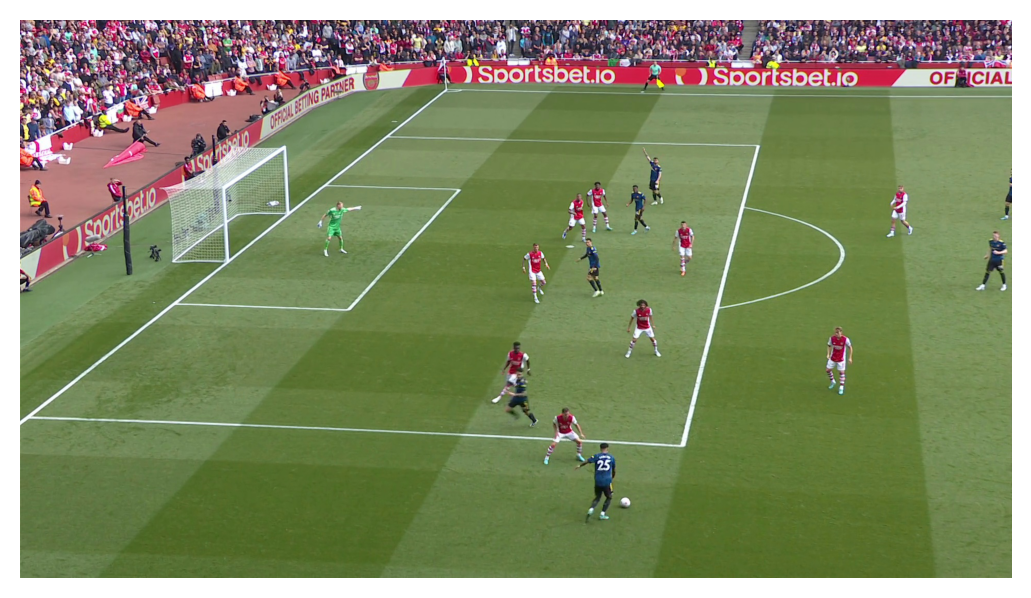

In [1]:
import base64
import json
import io
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
with open('example-football-pitch-image.jpg', "rb") as image_file:
   encoded_string = base64.b64encode(image_file.read())
image_data = base64.b64decode(encoded_string)
image = Image.open(io.BytesIO(image_data))
plt.gcf().set_dpi(200)
plt.axis('off')
plt.imshow(image)
plt.show()

Now, I am going to make our first call to the AI Vision service. I will send a request to run Object Detection and Text Detection.

In [2]:
import oci
config = oci.config.from_file('~/.oci/config')
ai_service_vision_client = oci.ai_vision.AIServiceVisionClient(config=config)
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()
image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = 255
image_text_detection_feature = oci.ai_vision.models.ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]
inline_image_details.data = encoded_string.decode('utf-8')
analyze_image_details.image = inline_image_details
analyze_image_details.features = features
res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)
res_json = json.loads(repr(res.data))
f = open('vision_response.json', 'w')
json.dump(res_json, f)
f.close()

Notice how I am building a parameter called **analyze_image_details**. I ask AI Vision with so-called "features" to do Object Recognition as well as Text Recognition. And, of course, I supply the image to be analyzed.

See the results

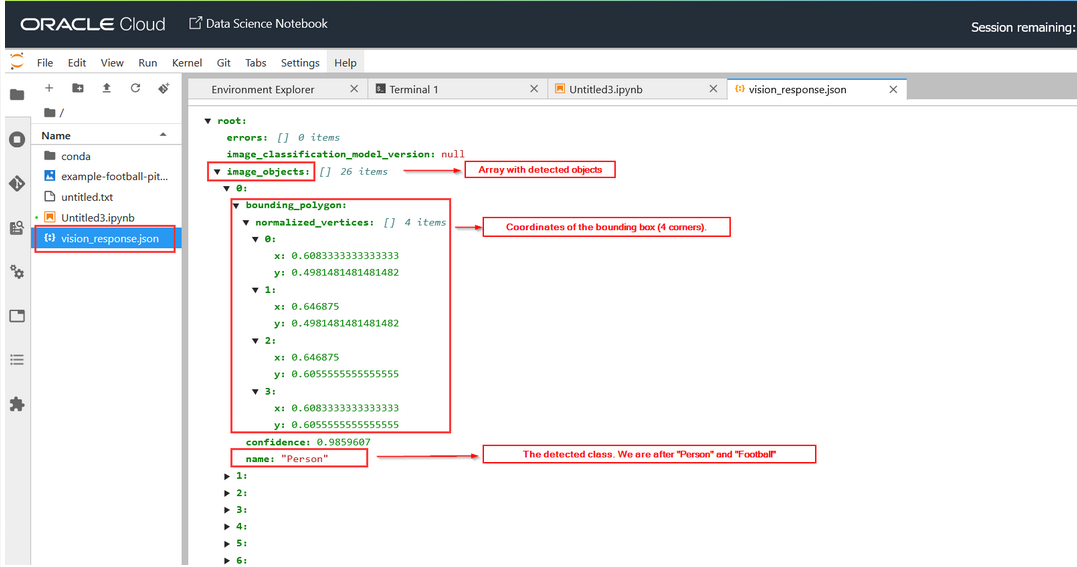

First open the "image_objects" key. Notice how it contains all the objects that were detected in the frame. For each detection, it contains a "bounding_polygon", which contains the coordinates of the 4 corners of the bounding box, as well as "name", which contains the class of the object, such as "Person" and "Football". 

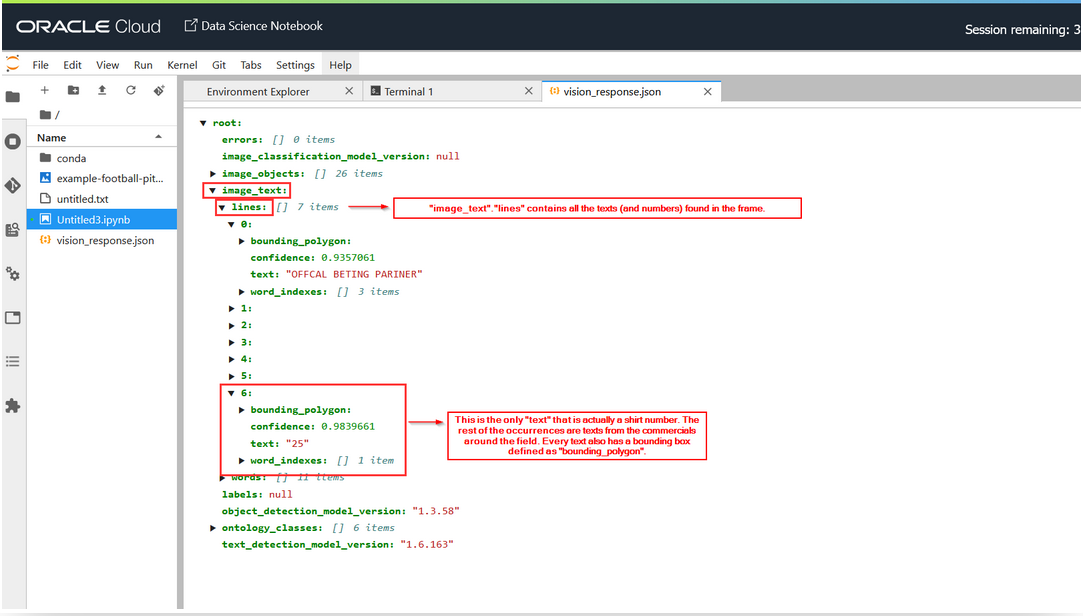

Now I am going to visualize the boxes.

Notice how this loops through a) The recognized objects and b) The recognized texts. It will draw a bounding box for each of the detection by drawing lines between all of the corners ("vertices"). 

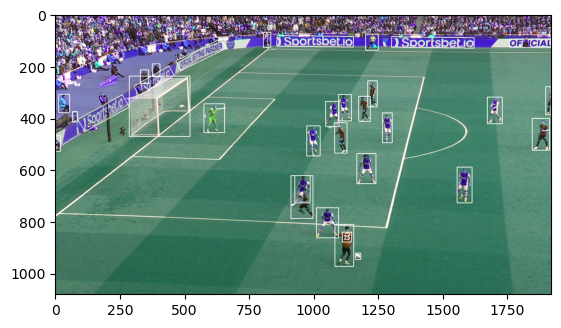

In [3]:
import cv2
def draw_bounding_boxes(objects, img):
    width = img.shape[1]
    height = img.shape[0]
    # Loop through all of the players found
    for obj in objects:
        point1 = (int(obj["bounding_polygon"]["normalized_vertices"][0]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][0]["y"] * height))
        point2 = (int(obj["bounding_polygon"]["normalized_vertices"][1]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][1]["y"] * height))
        point3 = (int(obj["bounding_polygon"]["normalized_vertices"][2]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][2]["y"] * height))
        point4 = (int(obj["bounding_polygon"]["normalized_vertices"][3]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][3]["y"] * height))
        color = (255, 255, 255)
        cv2.line(img, point1, point2, color, 2)
        cv2.line(img, point2, point3, color, 2)
        cv2.line(img, point3, point4, color, 2)
        cv2.line(img, point4, point1, color, 2)
img = cv2.imread('example-football-pitch-image.jpg')
draw_bounding_boxes(res_json["image_objects"], img)
draw_bounding_boxes(res_json["image_text"]["lines"], img)
plt.imshow(img)
plt.show()

Notice how all the players, the football, and the single visible shirt number (25) are all inside of a bounding box. There are still some problems though: a) There are a number of Persons recognized that are not players (outside of the field). b) There are a number of texts marked that are not shirt numbers.

## Connect T-shirt Number with player

Although I have detected the objects (players) and text (shirt numbers), I still don't know which shirt number belongs to which player.

I will solve this challenge by checking which texts are within the bounding boxes of which object. For example, in this case, the number 25 is within the boundaries of the player.

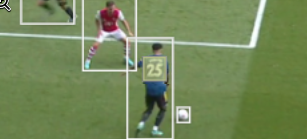

It is my goal to add any shirt number to the "image_object" data structure for each player.

I will add a key "shirt_number" in case the player has an identified shirt number. I want to add this key in each occurrence of the elements of "image_objects" (if a shirt number has been found for that player).

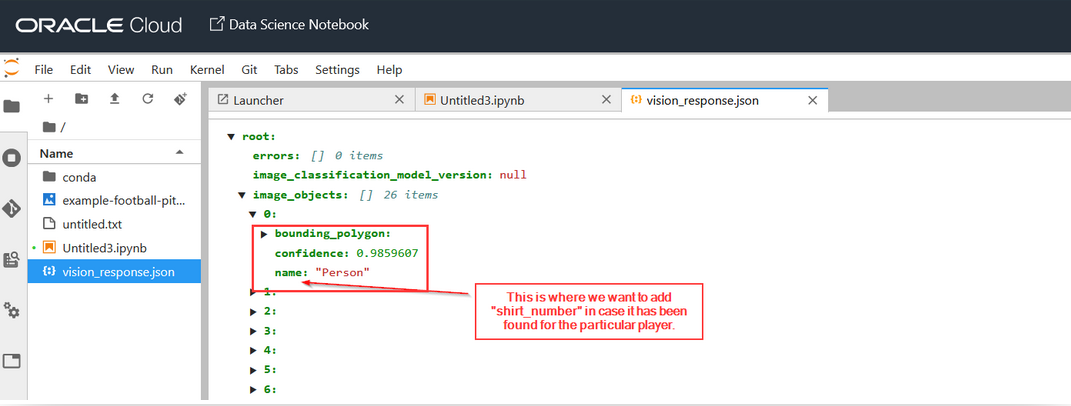

In [4]:
def is_point_within_rectangle(object_rectangle, text_rectangle):
    minX = 1
    maxX = 0
    minY = 1
    maxY = 0
    for coordinate in object_rectangle:
        if coordinate["x"] < minX:
            minX = coordinate["x"]
        if coordinate["y"] < minY:
            minY = coordinate["y"]
        if coordinate["x"] > maxX:
            maxX = coordinate["x"]
        if coordinate["y"] > maxY:
            maxY = coordinate["y"]
    result = text_rectangle[0]["x"] > minX and text_rectangle[0]["y"] > minY and text_rectangle[0]["x"] < maxX and text_rectangle[0]["y"] < maxY and text_rectangle[1]["x"] > minX and text_rectangle[1]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[1]["y"] < maxY and text_rectangle[2]["x"] > minX and text_rectangle[2]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[2]["y"] < maxY and text_rectangle[3]["x"] > minX and text_rectangle[3]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[3]["y"] < maxY
    return result
def add_shirt_number_to_players(vision_response):
    # Loop through all of the players found
    for image_object in vision_response["image_objects"]:
        # Loop through all of the texts found
        # Check if it is within the bounds of this player
        # If it is, then set it as the shirt number
        for line in vision_response["image_text"]["lines"]:
            result = is_point_within_rectangle(image_object["bounding_polygon"]["normalized_vertices"], line["bounding_polygon"]["normalized_vertices"])
            if (result is True):
                image_object["shirt_number"] = line["text"]
                print(image_object)
add_shirt_number_to_players(res_json)
f = open('vision_response_enriched_with_shirt_numbers.json', 'w')
json.dump(res_json, f)
f.close()

{'bounding_polygon': {'normalized_vertices': [{'x': 0.5640625, 'y': 0.7509259259259259}, {'x': 0.6020833333333333, 'y': 0.7509259259259259}, {'x': 0.6020833333333333, 'y': 0.9009259259259259}, {'x': 0.5640625, 'y': 0.9009259259259259}]}, 'confidence': 0.97589386, 'name': 'Person', 'shirt_number': '25'}


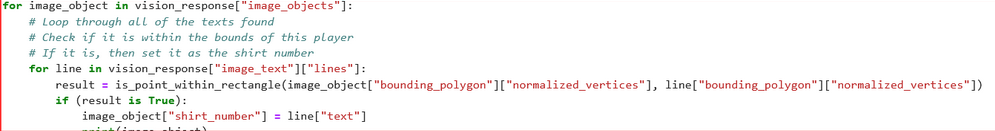

The highlighted piece of code loops through all of the recognized players, and, for each player, loops through all of the texts that were recognized. If the text is within the bounding box of the player (using "is_point_within_rectangle"), the shirt number is added to the player.

Open the "vision_response_enriched_with_shirt_numbers.json" file.

Search through the elements of "image_objects". Notice how shirt number "25" has been added to one of the players.

Later on I will us this in the pipeline to show the shirt number next to each player.

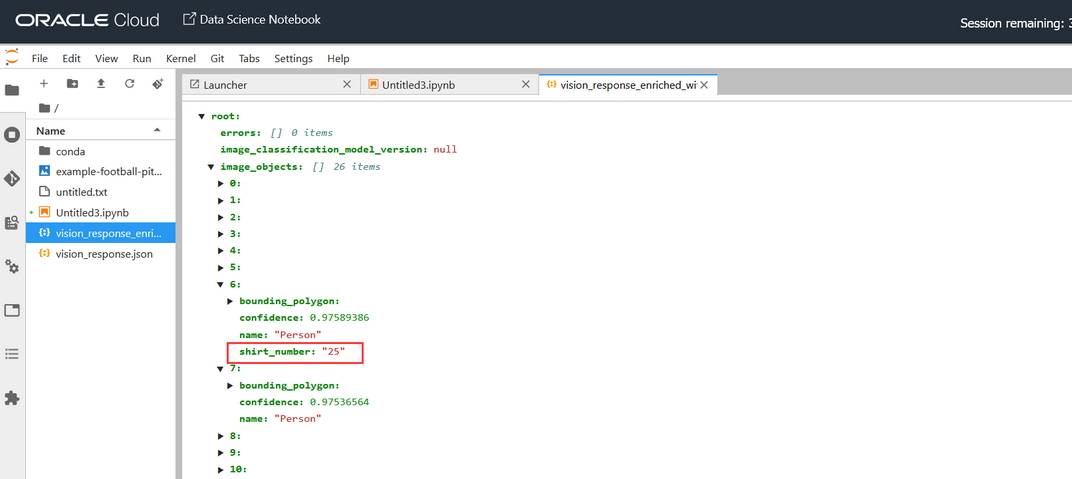

## Translate Camera Coordinates to Football Pitch Coordinates

**Introduction**

I now have the position of the bounding boxes, but those coordinates are expressed in terms of a flat 2D image (the camera coordinate system). What I am really interested in, is the coordinates of the players/ball on the football pitch. The question is: How can I take the position from the 2D image from the camera and project it onto the coordinate system of the football pitch? The following image shows what we are trying to achieve:

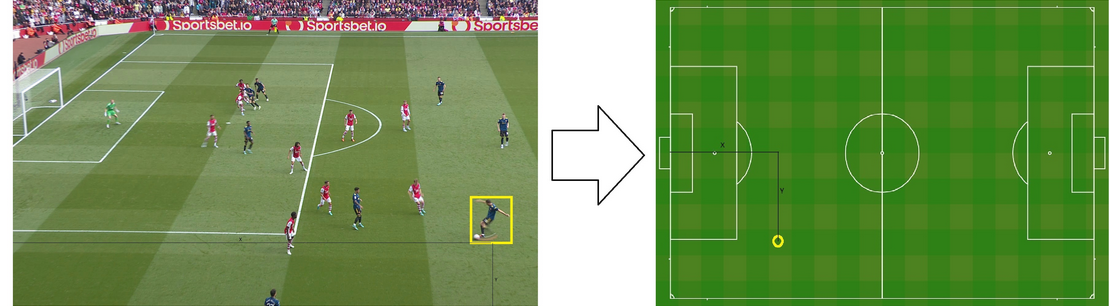

What I am looking for is a so-called “Homography” translation. This can take any square and transform it into any other quadrilateral and vice versa, like this:

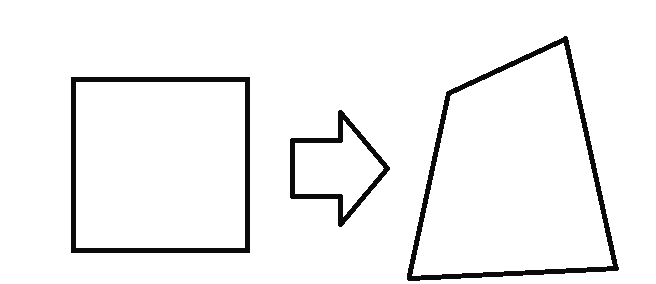

Mathematically, this transformation is represented as a 3x3 matrix. The question is, how can I obtain the right values for this matrix? I have chosen the approach to calculate the homography matrix from known pairs of camera and matching football pitch coordinates. For this calculation, at least 4 pairs are necessary. In other words, if we know the camera coordinates (pixels X and Y), and I know the real world location on the pitch, and I have at least 4 of those pairs, then I can calculate the translation matrix. In this case, I have already done this for you. We have manually annotated each frame in the football video with at least 4 recognizable markers (e.g. the corners of the penalty area, or the middle corners of the goal area). What this means for you, is that you can load the 4 coordinate_pairs for each frame, and use Python to calculate the translation.

Estimated Time: 30 minutes
Objectives

    You will modify the notebook to load the 4 pairs of camera and matching football pitch coordinates for the frame.
    You will calculate the homography matrix from it.
    You will display the outlines of the field to show that the homography is correct.
    You will translate the positions of the players from camera space to coordinates on the pitch.
    You will remove any recognized objects that are outside of the field limits.
    
#### Task: Calculate the homography matrix for a single frame and draw field lines on the image

Download the coordinate_pairs.json file to your machine.

Save the file on your local machine. Make sure that the file is saved with extension .json.

Upload the file to the notebook.

Open the JSON file.

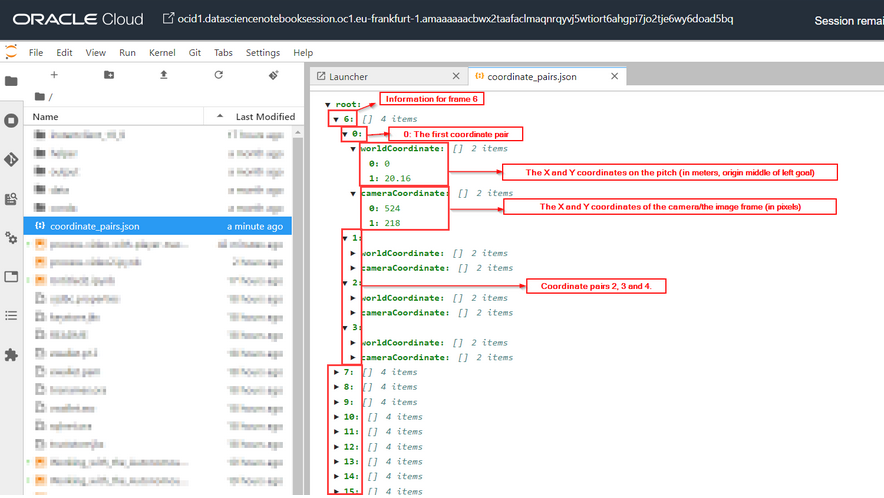

Notice how there are 4 coordinate pairs (pitch + matching camera coordinate) for each frame of the video. The file starts at frame 6 because the 5 first frames display the Premier League logo (there is no field visible on the first 5 frames).

Now I create a function to delimitate the football field

In [5]:
def is_point_within_rectangle(object_rectangle, text_rectangle):
    #This is used to check whether the detected number is inside of a detected player
    #If it is, then it is a shirt number
    #If it is not, it's likely a commercial message outside of the field
    minX = 1
    maxX = 0
    minY = 1
    maxY = 0
    for coordinate in object_rectangle:
        if coordinate["x"] < minX:
            minX = coordinate["x"]
        if coordinate["y"] < minY:
            minY = coordinate["y"]
        if coordinate["x"] > maxX:
            maxX = coordinate["x"]
        if coordinate["y"] > maxY:
            maxY = coordinate["y"]
    result = text_rectangle[0]["x"] > minX and text_rectangle[0]["y"] > minY and text_rectangle[0]["x"] < maxX and text_rectangle[0]["y"] < maxY and text_rectangle[1]["x"] > minX and text_rectangle[1]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[1]["y"] < maxY and text_rectangle[2]["x"] > minX and text_rectangle[2]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[2]["y"] < maxY and text_rectangle[3]["x"] > minX and text_rectangle[3]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[3]["y"] < maxY
    return result
def add_shirt_number_to_players(vision_response):
    # Loop through all of the players found
    for image_object in vision_response["image_objects"]:
        # Loop through all of the texts found
        # Check if it is within the bounds of this player
        # If it is, then set it as the shirt number
        for line in vision_response["image_text"]["lines"]:
            result = is_point_within_rectangle(image_object["bounding_polygon"]["normalized_vertices"], line["bounding_polygon"]["normalized_vertices"])
            if (result is True):
                image_object["shirt_number"] = line["text"]
add_shirt_number_to_players(res_json)
f = open('vision_response_enriched_with_shirt_numbers.json', 'w')
json.dump(res_json, f)


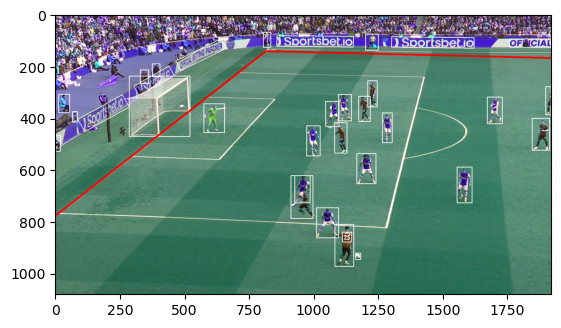

In [6]:
def draw_line_with_field_coordinates(field_coordinate1, field_coordinate2, img, field_to_camera):
    # provide a point you wish to map from image 1 to image 2
    a = np.array([field_coordinate1], dtype='float32')
    a = np.array([a])
    #print("a", a)
    b = np.array([field_coordinate2], dtype='float32')
    b = np.array([b])
    # finally, get the mapping
    pointsOut1 = cv2.perspectiveTransform(a, field_to_camera)
    pointsOut2 = cv2.perspectiveTransform(b, field_to_camera)
    coordinate1 = pointsOut1[0][0]
    coordinate1int = coordinate1.astype(int)
    coordinate1tuple = (coordinate1int[0], coordinate1int[1])
    #print(coordinate1tuple)
    coordinate2 = pointsOut2[0][0]
    coordinate2int = coordinate2.astype(int)
    coordinate2tuple = (coordinate2int[0], coordinate2int[1])
    #print(coordinate2tuple)
    cv2.line(img, coordinate1tuple, coordinate2tuple, (255, 0, 0), 5)
# Read the precalculated homography translation matrices (for all frames)
import numpy as np
f = open('coordinate_pairs.json', 'r')
homography_str = f.read()
homography_dict = json.loads(homography_str)

frame_coordinate_pairs = homography_dict["23"]
pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
field_to_camera, status = cv2.findHomography(pts_dst, pts_src)
FIELD_HEIGHT = 65
FIELD_WIDTH = 105
draw_line_with_field_coordinates([0, -FIELD_HEIGHT / 2], [0, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([0, FIELD_HEIGHT / 2], [FIELD_WIDTH, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, FIELD_HEIGHT / 2], [FIELD_WIDTH, -FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, -FIELD_HEIGHT / 2], [0, -FIELD_HEIGHT / 2], img, field_to_camera)
#ADD YOUR OWN CODE HERE TO DRAW THE PENALTY AREA
plt.imshow(img)
plt.show()


Go to the last cell to inspect the coordinate translation logic. Notice how it loads the coordinate pairs file, and calculates two homography matrices for the frame. The first matrix is the translation from camera coordinates to world coordinates, and the second matrix is the translation from world coordinates to camera coordinates.

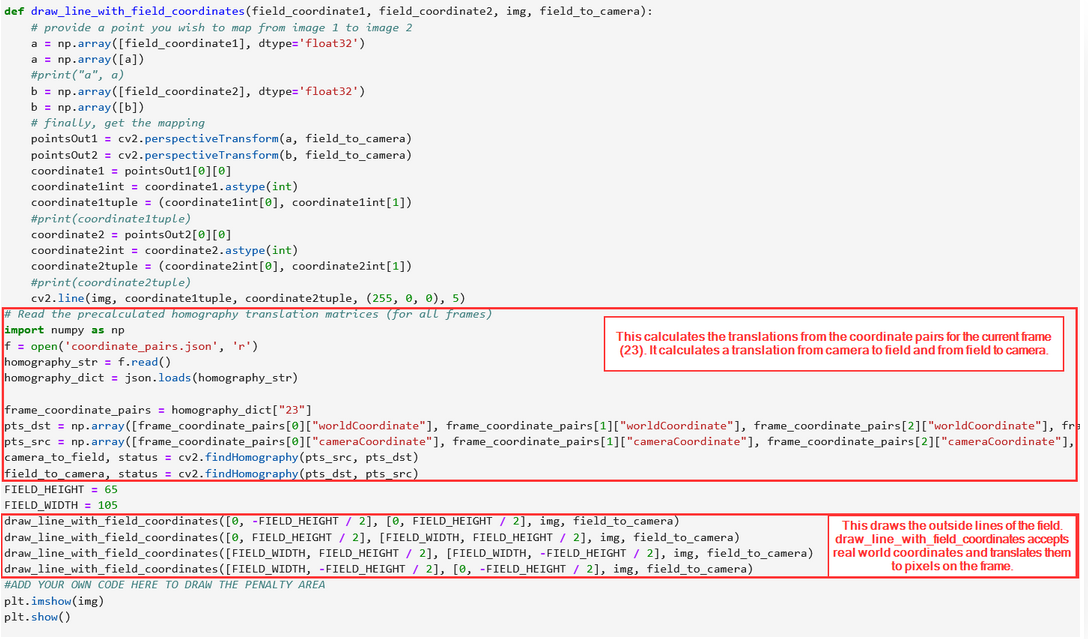

Notice also how there is code that will draw lines on the field, taking real world coordinates (on the pitch, in meters) as an input. The draw_line_with_field_coordinates function will first translate these coordinates from to the corresponding coordinates on the frame (in pixels), and then draw the line.

##### I am going to calculate the penalty area

This picture can used as a real world coordinates. 

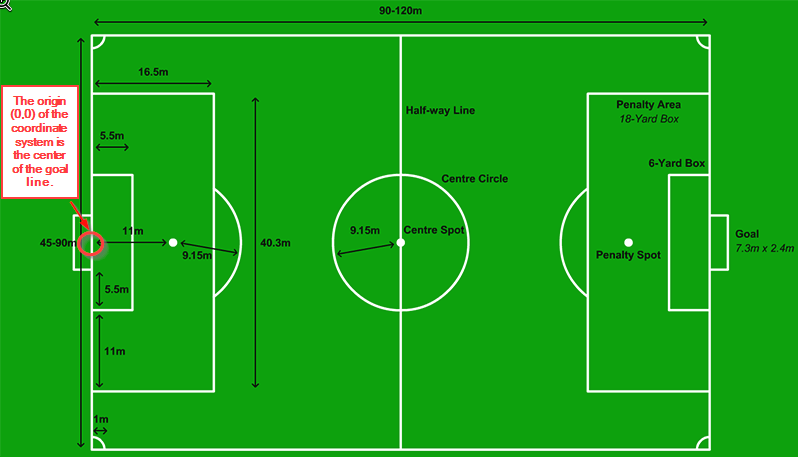


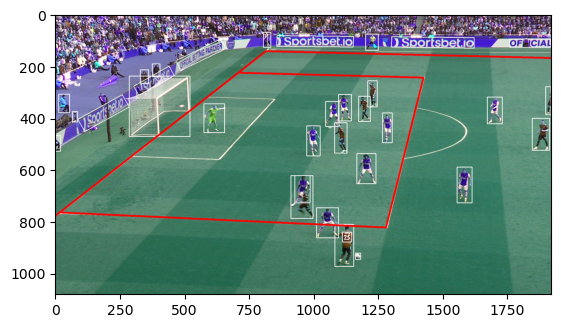

In [7]:
import numpy as np
f = open('coordinate_pairs.json', 'r')
homography_str = f.read()
homography_dict = json.loads(homography_str)

frame_coordinate_pairs = homography_dict["23"]
pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
field_to_camera, status = cv2.findHomography(pts_dst, pts_src)

# Field area
FIELD_HEIGHT = 65
FIELD_WIDTH = 105
draw_line_with_field_coordinates([0, -FIELD_HEIGHT / 2], [0, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([0, FIELD_HEIGHT / 2], [FIELD_WIDTH, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, FIELD_HEIGHT / 2], [FIELD_WIDTH, -FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, -FIELD_HEIGHT / 2], [0, -FIELD_HEIGHT / 2], img, field_to_camera)

# Penalty area
PENALTY_HEIGHT = 40.3
PENALTY_WIDTH = 16.5
draw_line_with_field_coordinates([0, PENALTY_HEIGHT / 2], [PENALTY_WIDTH, PENALTY_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([PENALTY_WIDTH, PENALTY_HEIGHT / 2], [PENALTY_WIDTH, -PENALTY_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([PENALTY_WIDTH, -PENALTY_HEIGHT / 2], [0, -PENALTY_HEIGHT / 2], img, field_to_camera)
#ADD YOUR OWN CODE HERE TO DRAW THE PENALTY AREA
plt.imshow(img)
plt.show()

#### Task: Translate player coordinates to real world coordinates

Now I am going to translate the player coordinates to real world coordinates. I will need this for tracking purposes. Any statistics that we want to calculate will need the real world coordinates of the players (and not the coordinates in the camera space).

In [8]:
def add_object_world_coordinates(image_objects, img, camera_to_field):
    for image_object in image_objects:
        width = img.shape[1]
        height = img.shape[0]
        vertices = image_object["bounding_polygon"]["normalized_vertices"]
        vertex_x = vertices[0]['x'] * width
        vertex_y = vertices[0]['y'] * height
        box_width = (vertices[2]['x'] - vertices[0]['x']) * width
        box_height = (vertices[2]['y'] - vertices[0]['y']) * height
        camera_location = np.array([[int(vertex_x + (box_width / 2)), int(vertex_y + box_height)]], dtype='float32')
        camera_location = np.array([camera_location])
        world_location = cv2.perspectiveTransform(camera_location, camera_to_field)
        world_location = [float(world_location[0][0][0]), float(world_location[0][0][1])]
        image_object["world_coordinates"] = world_location
add_object_world_coordinates(res_json["image_objects"], img, camera_to_field)
f = open('vision_response_enriched_with_world_coordinates.json', 'w')
json.dump(res_json, f)
f.close()

Notice how this takes the pixels coordinates of the bottom middle of the bounding box, between the feet of the players. It translates these coordinates to real world coordinates on the pitch using the camera_to_field translation matrix that we calculated earlier.

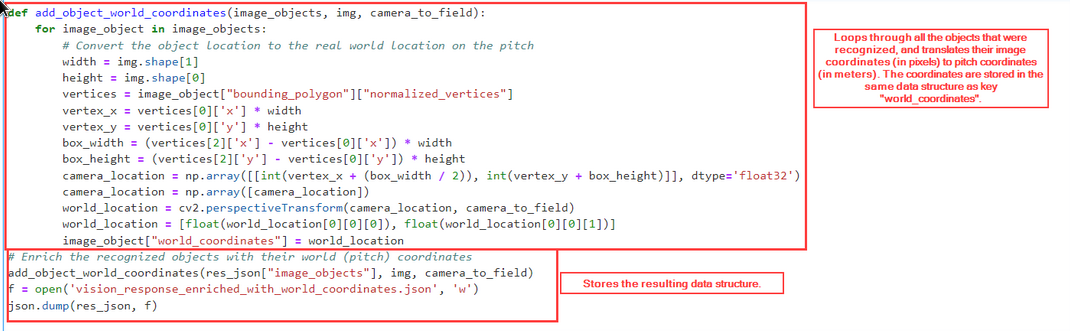

Run the code and inspect the resulting JSON document "vision_response_enriched_with_world_coordinates.json".

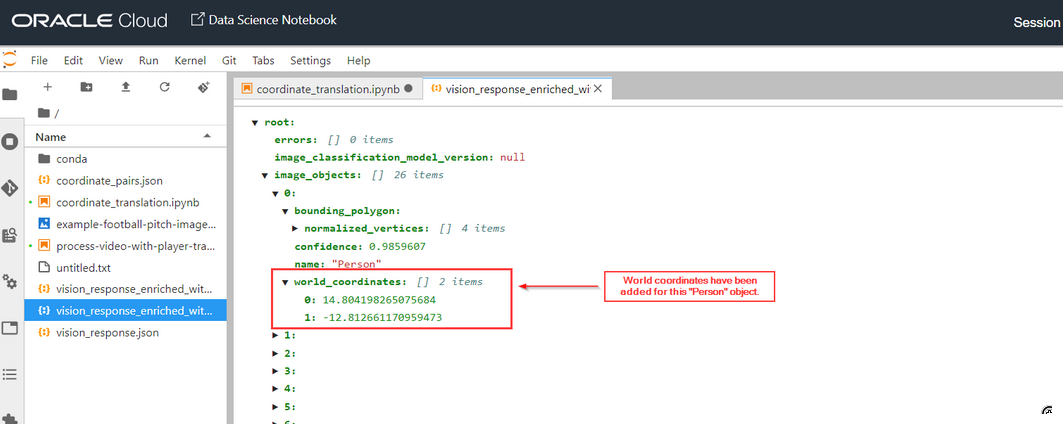

Notice how the key "world_coordinates" has been added for this player (this has been done for all objects).

#### The next challenge is to remove any objects (players) that are outside of the pitch.

Adapt the placeholder by including a condition to only display players that are inside of the football pitch limits. I will do this to filter out all of the objects outside of the field.

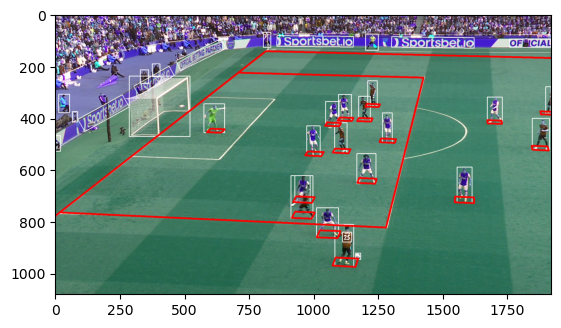

In [9]:
def draw_player_field_markers(image_objects, img, field_to_camera):
    for image_object in image_objects:
        world_coordinates = image_object["world_coordinates"]
        if "display" in image_object and image_object["name"] == "Person":
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]], img, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]-0.5, world_coordinates[1]+1], img, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]+0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]+1], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, field_to_camera)
def remove_unwanted_objects(image_objects):
    for index, image_object in enumerate(image_objects):
        world_coordinate = image_object["world_coordinates"]
        if world_coordinate[0] > 0 and world_coordinate[0] < FIELD_WIDTH and world_coordinate[1] > (-FIELD_HEIGHT / 2) and world_coordinate[1] < (FIELD_HEIGHT / 2):
            image_object["display"] = "Y"
remove_unwanted_objects(res_json["image_objects"])
draw_player_field_markers(res_json["image_objects"], img, field_to_camera)
plt.imshow(img)
plt.show()

## Connect OCI Data Science with Autonomous Data Warehouse
**Introduction**

Once I have the tracking information, I will want to extract all kinds of statistics from it. For example, a scout may want to calculate statistics on Player Performance. A coach may want to look at Expected Goals, etcetera. In order to give analysts like the scout and the coach easy access to the data for their analysis, I will store all the information that we extract (from the videos) in the Autonomous Data Warehouse.

In this lab I will set up the connection between our OCI Data Science notebook and Autonomous Data Warehouse

Estimated Time: 15 minutes
Objectives

In this lab you will:

    Download the wallet from Autonomous Data Warehouse.
    Configure OCI Data Science to connect with ADW.

In [ ]:
!pip install oracledb
import oracledb
connection = oracledb.connect(
     user='admin',
     password='XXXXXX',
     dsn='pl_high',
     config_dir='/home/datascience/wallet',
     wallet_location='/home/datascience/wallet',
     wallet_password='YYYYYY')
cur = connection.cursor()
cur.execute("create table tracking(framenumber number, object varchar2(10), shirt_number number, position_x number, position_y number)")

Now I am going to store the tracking information for this single frame in the TRACKING table.

In [11]:
def store_tracking_information(image_objects):
    for index, image_object in enumerate(image_objects):
        world_coordinate = image_object["world_coordinates"]
        if "display" in image_object:
            sql = ""
            if image_object["name"] == "Person":
                shirt_number = "null"
                if "shirt_number" in image_object:
                    shirt_number = image_object["shirt_number"]
                sql = "insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', " + shirt_number + ", " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            if image_object["name"] == "Football":
                sql = "insert into tracking(framenumber, object, position_x, position_y) values (23, \'Ball\', " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            print(sql)
            cur.execute(sql)
store_tracking_information(res_json["image_objects"])
connection.commit()

insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 14.804198265075684, -12.812661170959473)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 13.894822120666504, -21.991180419921875)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 20.237119674682617, -15.627877235412598)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 15.214344024658203, -3.424839496612549)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 3.461827278137207, -2.3310816287994385)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', null, 24.922182083129883, -3.961078405380249)
insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (23, 'Player', 25, 15.

Notice how the store_tracking_information function creates INSERT statements to store the tracking information of the players and the ball in the TRACKING table.

## Translate Camera Coordinates to Football Pitch Coordinates
**Introduction**

I now have the ingredients to process a video. I am going to add a video to the notebook and process it frame by frame. The results of this process will be a) An augmented video (with boxes, and shirt numbers) and b) Tracking information in the database.

Estimated Time: 20 minutes
Objectives

    Load an existing notebook with the full pipeline.
    Configure the details of your database connection (as you did in a previous lab).
    Inspect some interesting parts of the code with mechanisms that we hadn't covered yet.
    Run the pipeline and inspect the resulting video.
    
Download the video here throught terminal: 

    wget https://objectstorage.us-ashburn-1.oraclecloud.com/p/EwriB0Oq1hUYAPvkceXZMLTsxcywHAimwkYVc-l03mxWzVWGX79a8QO1lap5wMXz/n/c4u04/b/livelabsfiles/o/ai-ml-library/pl-analysis-video4.mp4 -O video.mp4


In [12]:
import base64
import json
import io
import os
import requests
import oci
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import math

In [13]:
config = oci.config.from_file('~/.oci/config')
ai_service_vision_client = oci.ai_vision.AIServiceVisionClient(config=config)

In [14]:
def draw_player_field_markers(image_objects, img, field_to_camera):
    # Draws a 1 by 1 meter box right below the feet of the player
    color = (255, 0, 0)
    for image_object in image_objects:
        world_coordinates = image_object["world_coordinates"]
        if "display" in image_object and image_object["name"] == "Person":
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]-0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]+0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]+1], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)


In [16]:
def remove_unwanted_objects(image_objects):
    for index, image_object in enumerate(image_objects):
        # Only include objects inside of the field (looking at the real world coordinates), otherwise it's likely a referree/audience/reporter or other object
        world_coordinate = image_object["world_coordinates"]
        label = image_object["name"]
        if world_coordinate[0] > 0 and world_coordinate[0] < FIELD_WIDTH and world_coordinate[1] > (-FIELD_HEIGHT / 2) and world_coordinate[1] < (FIELD_HEIGHT / 2):
            image_object["display"] = "Y"


In [17]:
def is_point_within_rectangle(object_rectangle, text_rectangle):
    # This checks whether the text is within a players bounding box (and therefore a shirt number)
    minX = 1
    maxX = 0
    minY = 1
    maxY = 0
    for coordinate in object_rectangle:
        if coordinate["x"] < minX:
            minX = coordinate["x"]
        if coordinate["y"] < minY:
            minY = coordinate["y"]
        if coordinate["x"] > maxX:
            maxX = coordinate["x"]
        if coordinate["y"] > maxY:
            maxY = coordinate["y"]
    result = text_rectangle[0]["x"] > minX and text_rectangle[0]["y"] > minY and text_rectangle[0]["x"] < maxX and text_rectangle[0]["y"] < maxY and text_rectangle[1]["x"] > minX and text_rectangle[1]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[1]["y"] < maxY and text_rectangle[2]["x"] > minX and text_rectangle[2]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[2]["y"] < maxY and text_rectangle[3]["x"] > minX and text_rectangle[3]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[3]["y"] < maxY
    return result


In [18]:
# Field height and width can vary
FIELD_HEIGHT = 65
FIELD_WIDTH = 105

field_coordinates = np.array([
    # Left
    [0, 0], # Left side, center of goal on goal line
    [0, 7.32 / 2], # Left side, top of goal
    [0, -7.32 / 2], # Left side, bottom of goal
    [11, 0], # Left side, penalty spot
    [0, (7.32 / 2) + 5.5], # Left side, top outer corner of goal area
    [0, (-7.32 / 2) - 5.5], # Left side, bottom outer corner of goal area
    [5.5, (7.32 / 2) + 5.5], # Left side, top inner corner of goal area
    [5.5, (-7.32 / 2) - 5.5], # Left side, bottom inner corner of goal area
    [0, (7.32 / 2) + 16.5], # Left side, top outer corner of penalty area
    [0, (-7.32 / 2) - 16.5], # Left side, bottom outer corner of penalty area
    [16.5, (7.32 / 2) + 16.5], # Left side, top inner corner of penalty area
    [16.5, (-7.32 / 2) - 16.5], # Left side, bottom inner corner of penalty area
    [16.5, 7.31], # Left side, top of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [16.5, -7.31], # Left side, bottom of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [0, FIELD_HEIGHT / 2], # Left side, top corner of field
    [0, -FIELD_HEIGHT / 2], # Left side, bottom corner of field
    # Right
    [FIELD_WIDTH, 0], # Right side, center of goal on goal line
    [FIELD_WIDTH, 7.32 / 2], # Right side, top of goal
    [FIELD_WIDTH, -7.32 / 2], # Right side, bottom of goal
    [FIELD_WIDTH-11, 0], # Right side, penalty spot
    [FIELD_WIDTH, (7.32 / 2) + 5.5], # Right side, top outer corner of goal area
    [FIELD_WIDTH, (-7.32 / 2) - 5.5], # Right side, bottom outer corner of goal area
    [FIELD_WIDTH-5.5, (7.32 / 2) + 5.5], # Right side, top inner corner of goal area
    [FIELD_WIDTH-5.5, (-7.32 / 2) - 5.5], # Right side, bottom inner corner of goal area
    [FIELD_WIDTH, (7.32 / 2) + 16.5], # Right side, top outer corner of penalty area
    [FIELD_WIDTH, (-7.32 / 2) - 16.5], # Right side, bottom outer corner of penalty area
    [FIELD_WIDTH-16.5, (7.32 / 2) + 16.5], # Right side, top inner corner of penalty area
    [FIELD_WIDTH-16.5, (-7.32 / 2) - 16.5], # Right side, bottom inner corner of penalty area
    [FIELD_WIDTH-16.5, 7.31], # Right side, top of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [FIELD_WIDTH-16.5, -7.31], # Right side, bottom of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [FIELD_WIDTH, FIELD_HEIGHT / 2], # Right side, top corner of field
    [FIELD_WIDTH, -FIELD_HEIGHT / 2], # Right side, bottom corner of field
    # Middle stuff
    [FIELD_WIDTH / 2, FIELD_HEIGHT / 2], # Top of middle line
    [FIELD_WIDTH / 2, -FIELD_HEIGHT / 2], # Bottom of middle line
    [FIELD_WIDTH / 2, 0], # Center spot
])

In [19]:
def draw_line_with_field_coordinates(field_coordinate1, field_coordinate2, img, line_width, color, field_to_camera):
    # Draws a line on the image, taking as input real world coordinates (in meters on the pitch)
    # It translates the pitch coordinates to pixels on the image using the field_to_camera translation matrix first
    a = np.array([field_coordinate1], dtype='float32')
    a = np.array([a])
    b = np.array([field_coordinate2], dtype='float32')
    b = np.array([b])
    pointsOut1 = cv2.perspectiveTransform(a, field_to_camera)
    pointsOut2 = cv2.perspectiveTransform(b, field_to_camera)
    coordinate1 = pointsOut1[0][0]
    coordinate1int = coordinate1.astype(int)
    coordinate1tuple = (coordinate1int[0], coordinate1int[1])
    coordinate2 = pointsOut2[0][0]
    coordinate2int = coordinate2.astype(int)
    coordinate2tuple = (coordinate2int[0], coordinate2int[1])
    cv2.line(img, coordinate1tuple, coordinate2tuple, color, line_width)
def draw_field(img):
    # Left penalty area
    color = (255, 255, 255)
    draw_line_with_field_coordinates(field_coordinates[8], field_coordinates[10], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[10], field_coordinates[11], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[11], field_coordinates[9], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[9], field_coordinates[8], img, 5, color, field_to_camera)
    # Left goal area
    draw_line_with_field_coordinates(field_coordinates[4], field_coordinates[6], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[6], field_coordinates[7], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[7], field_coordinates[5], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[5], field_coordinates[4], img, 5, color, field_to_camera)
    # Right penalty area
    draw_line_with_field_coordinates(field_coordinates[8+16], field_coordinates[10+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[10+16], field_coordinates[11+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[11+16], field_coordinates[9+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[9+16], field_coordinates[8+16], img, 5, color, field_to_camera)
    # Left goal area
    draw_line_with_field_coordinates(field_coordinates[4+16], field_coordinates[6+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[6+16], field_coordinates[7+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[7+16], field_coordinates[5+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[5+16], field_coordinates[4+16], img, 5, color, field_to_camera)
    # Middle line
    draw_line_with_field_coordinates(field_coordinates[32], field_coordinates[33], img, 5, color, field_to_camera)
    # Distance lines
    for i in range(0, FIELD_WIDTH, 2):
        draw_line_with_field_coordinates([i, -FIELD_HEIGHT / 2], [i, FIELD_HEIGHT / 2], img, 1, color, field_to_camera)
    for i in range(0, FIELD_HEIGHT, 2):
        draw_line_with_field_coordinates([0, i - (FIELD_HEIGHT / 2)], [FIELD_WIDTH, i - (FIELD_HEIGHT / 2)], img, 1, color, field_to_camera)


In [20]:
def add_object_world_coordinates(image_objects, img, camera_to_field):
    # Translates pixels coordinates of the objects to real world pitch coordinates
    for image_object in image_objects:
        width = img.shape[1]
        height = img.shape[0]
        vertices = image_object["bounding_polygon"]["normalized_vertices"]
        vertex_x = vertices[0]['x'] * width
        vertex_y = vertices[0]['y'] * height
        box_width = (vertices[2]['x'] - vertices[0]['x']) * width
        box_height = (vertices[2]['y'] - vertices[0]['y']) * height
        camera_location = np.array([[int(vertex_x + (box_width / 2)), int(vertex_y + box_height)]], dtype='float32')
        camera_location = np.array([camera_location])
        world_location = cv2.perspectiveTransform(camera_location, camera_to_field)
        world_location = [float(world_location[0][0][0]), float(world_location[0][0][1])]
        image_object["world_coordinates"] = world_location


In [21]:
def add_shirt_number_to_players(vision_response):
    # Adds the shirt numbers to the players
    # Does this by checking whether the recognized text is within the bounding box of the player
    for image_object in vision_response["image_objects"]:
        # Loop through all of the texts found
        # Check if it is within the bounds of this player
        # If it is, then set it as the shirt number
        for line in vision_response["image_text"]["lines"]:
                result = is_point_within_rectangle(image_object["bounding_polygon"]["normalized_vertices"], line["bounding_polygon"]["normalized_vertices"])
                if (result is True):
                    if line["text"].isnumeric():
                        print("Found shirt number", line["text"])
                        image_object["shirt_number"] = line["text"]
                    else:
                        print("Ignoring non-number shirt text", line["text"])

In [22]:
def draw_player_info(image_objects, img):
    # Draws the box at the feet of the player
    # This uses real world pitch coordinates, therefore follows perspective of the image
    for image_object in image_objects:
        width = img.shape[1]
        height = img.shape[0]
        vertices = image_object["bounding_polygon"]["normalized_vertices"]
        label = image_object["name"]
        vertex_x = vertices[0]['x'] * width
        vertex_y = vertices[0]['y'] * height
        box_width = (vertices[2]['x'] - vertices[0]['x']) * width
        box_height = (vertices[2]['y'] - vertices[0]['y']) * height                        
        if label == "Person" and ("display" in image_object):
            if "shirt_number" in image_object:
                start_point = (int(vertex_x), int(vertex_y + box_height))
                end_point = (int(vertex_x + box_width), int(vertex_y + box_height + 30))
                color = (0, 0, 0)
                #cv2.rectangle(img, start_point, end_point, color, -1)
                cv2.putText(img, image_object["shirt_number"], (int(vertex_x + 15), int(vertex_y + box_height + 30)), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 255, 255), 3, 2)


In [23]:
def enrich_shirt_numbers_from_tracked_players(image_objects, tracked_players):
    for tracked_player in tracked_players:
        # Find the nearest player in the current frame
        #print("Trying to find best fitting player for coordinates ", tracked_player["world_coordinates"], " and shirt number", tracked_player["shirt_number"])
        shortest_distance = 99999
        image_object_with_shortest_distance = {}
        for image_object in image_objects:
            world_location_tracked = tracked_player["world_coordinates"]
            world_location_frame = image_object["world_coordinates"]
            distance = math.sqrt(((world_location_frame[0] - world_location_tracked[0]) * (world_location_frame[0] - world_location_tracked[0])) + ((world_location_frame[1] - world_location_tracked[1]) * (world_location_frame[1] - world_location_tracked[1])))
            if (distance < shortest_distance):
                shortest_distance = distance
                image_object_with_shortest_distance = image_object
        image_object_with_shortest_distance["shirt_number"] = tracked_player["shirt_number"]
        #print("setting shirt_number for player at distance", shortest_distance, tracked_player["shirt_number"])
    # Reset tracked players
    # Simply keep track of all the players with a shirt number
    tracked_players = []
    for image_object in image_objects:
        if "shirt_number" in image_object:
            tracked_player = {}
            tracked_player["shirt_number"] = image_object["shirt_number"]
            tracked_player["world_coordinates"] = image_object["world_coordinates"]
            tracked_players.append(tracked_player)
    return tracked_players


In [24]:
def store_tracking_information(image_objects, frame_number, connection, cur):
    # Stores the tracking information that was derived from the image in the database
    for index, image_object in enumerate(image_objects):
        world_coordinate = image_object["world_coordinates"]
        if "display" in image_object:
            sql = ""
            if image_object["name"] == "Person":
                shirt_number = "null"
                if "shirt_number" in image_object:
                    shirt_number = image_object["shirt_number"]
                sql = "insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (" + str(frame_number) + ", 'Player', " + shirt_number + ", " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            if image_object["name"] == "Football":
                sql = "insert into tracking(framenumber, object, position_x, position_y) values (" + str(frame_number) + ", \'Ball\', " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            cur.execute(sql)
    connection.commit()


In [27]:
def initialize_database_connection_and_table():
    # Initializes the connection to the database (we will use this to store the tracking information)
    import oracledb
    connection = oracledb.connect(
        user='User',
        password='XXXXXXXXXX',
        dsn='pl_high',
        config_dir='/home/datascience/wallet',
        wallet_location='/home/datascience/wallet',
        wallet_password='YYYYYYYYYY')
    cur = connection.cursor()
    try:
        cur.execute("create table tracking(framenumber number, object varchar2(10), shirt_number number, position_x number, position_y number)")
    except Exception:
        print("Could not create the tracking table, moving on...")
    try:
        cur.execute("truncate table tracking")
    except Exception:
        print("Could not empty the tracking table")
    return connection, cur


In [31]:
# Connect to the database
!pip install oracledb

#COMMENT THE FOLLOWING LINE IF YOU NOT WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
connection, cur = initialize_database_connection_and_table()

# Read the precalculated homography translation matrices (for all frames)
f = open('coordinate_pairs.json', 'r')
homographyStr = f.read()
homographyDict = json.loads(homographyStr)

# Configure features parameter for call to AI Vision service
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()
image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = 50 # We don't expect more than 50 objects
image_text_detection_feature = oci.ai_vision.models.ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]

# Video reader
filename = 'video.mp4'
cap = cv2.VideoCapture(filename)

# Video writer
out = cv2.VideoWriter('soccer_out.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (1920, 1080))

#Remove the first few frames (because it has a video overlay on top of the field)
for i in range(1, 15):
    ret, image_np = cap.read()
    
tracked_players = [] # Empty list

frame_number = 6
while (frame_number <= 80):
    # Read three frames from the video (we are skipping 2 frames, then processing the third)
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    _, im_arr = cv2.imencode('.jpg', image_np)  # im_arr: image in Numpy one-dim array format.
    
    # Call the AI Vision service to do object recognition and text recognition
    im_bytes = im_arr.tobytes()
    im_b64 = base64.b64encode(im_bytes)
    inline_image_details.data = im_b64.decode('utf-8')
    analyze_image_details.image = inline_image_details
    analyze_image_details.features = features
    res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)
    res_json = json.loads(repr(res.data))
    
    # Calculate the translation matrix for the current frame
    frame_coordinate_pairs = homographyDict[str(frame_number)]
    pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
    pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
    camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
    field_to_camera, status = cv2.findHomography(pts_dst, pts_src)

    # Data enrichment
    add_object_world_coordinates(res_json["image_objects"], image_np, camera_to_field)
    remove_unwanted_objects(res_json["image_objects"])
    add_shirt_number_to_players(res_json)
    tracked_players = enrich_shirt_numbers_from_tracked_players(res_json["image_objects"], tracked_players)

    # Create a mask for the underlying field (all the green pixels + some white pixels for the lines)
    img_hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(image_np, (213, 225, 204), (255, 255, 255))
    lower_green = np.array([40,40, 40])
    upper_green = np.array([70, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
    white_or_green_mask = cv2.bitwise_or(green_mask, white_mask)
    
    # Create an image of the same size as the original that will contain the augmentation elements (field lines, player marks, et cetera)
    drawing_canvas = np.zeros(image_np.shape[:3], dtype="uint8")
    #drawPlayerBoxes(clean_res, image_np)
    draw_field(drawing_canvas)
    draw_player_field_markers(res_json["image_objects"], drawing_canvas, field_to_camera)
    draw_player_info(res_json["image_objects"], drawing_canvas)
    
    # Remove the drawn elements in areas where there are no field pixels (effectively not drawing where there is a player or ball)
    drawing_canvas_masked = cv2.bitwise_and(drawing_canvas, drawing_canvas, mask=white_or_green_mask)
    img_augmented = cv2.bitwise_or(drawing_canvas_masked, image_np)

    #plt.imshow(img_augmented)
    #plt.gcf().set_dpi(200)
    #plt.show()
    
    # Add the resulting frame (with annotation) to the output video
    print("Writing to video, frame", frame_number)
    out.write(img_augmented)
    
    #COMMENT THE FOLLOWING LINE IF YOU NOT WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
    store_tracking_information(res_json["image_objects"], frame_number, connection, cur)

    frame_number += 1
cap.release()
out.release()

Could not create the tracking table, moving on...
Writing to video, frame 6
Writing to video, frame 7
Writing to video, frame 8
Ignoring non-number shirt text (a
Writing to video, frame 9
Found shirt number 25
Writing to video, frame 10
Found shirt number 2
Writing to video, frame 11
Writing to video, frame 12
Writing to video, frame 13
Found shirt number 2
Writing to video, frame 14
Writing to video, frame 15
Writing to video, frame 16
Found shirt number 2
Writing to video, frame 17
Ignoring non-number shirt text (
Writing to video, frame 18
Writing to video, frame 19
Found shirt number 25
Writing to video, frame 20
Found shirt number 25
Ignoring non-number shirt text -
Writing to video, frame 21
Found shirt number 25
Writing to video, frame 22
Found shirt number 25
Writing to video, frame 23
Found shirt number 2
Writing to video, frame 24
Found shirt number 25
Writing to video, frame 25
Writing to video, frame 26
Writing to video, frame 27
Writing to video, frame 28
Found shirt numbe

The code above is basically a loop that processes all the frames, and goes through all of the steps mentioned above. Have a look at the last cell of the notebook, and see if you can recognize all of these elements. 

The notebook will output every individual frame as an image. It will also produce an output video called "soccer_out.avi".

The processing will take a while, in the meantime, let's inspect some of the code. First, let's have a look at the logic to do player tracking.

With player tracking I refer to the idea that we remember where individual players are between frames. This is used to be able to show a shirt number, even when that shirt number is not visible in a certain frame. By using tracking I can "fill in the blanks" because we remember what the shirt number of the player was.

For example, in the frame on the left, the number 25 is clearly visible on the back of this player, and therefore it will be recognized by OCI Vision. A moment later, in the frame on the left, the number is not visible anymore. Notice, how I am still able to show "25" below the player, this is thanks to the player tracking mechanism.

Player tracking example

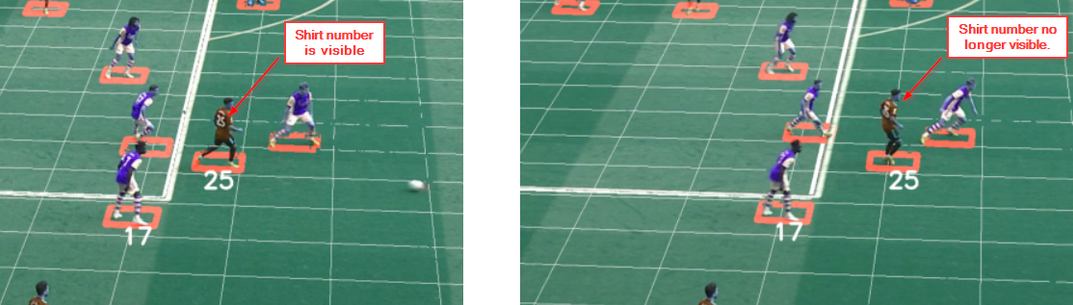

Have a look at the function enrich_shirt_numbers_from_tracked_players.

This function remembers where the players were with a shirt number in the previous frame.

Check out this line:

In [32]:
distance = math.sqrt(((world_location_frame[0] - world_location_tracked[0]) * (world_location_frame[0] - world_location_tracked[0])) + ((world_location_frame[1] - world_location_tracked[1]) * (world_location_frame[1] - world_location_tracked[1])))

NameError: name 'world_location_frame' is not defined

This calculates the distance between the players as recognized on the current frame, and the positions of which the players were in the previous frame (with shirt numbers). The function locates the player in the current frame that is closest to the position of where that shirt number was spotted in the previous frame, and adds that shirt number.
 
Let's have a look at the logic for **masking.**

I am using masking to only draw on the field, and not "on top of" the players. For example, notice how in the output below, the augmented drawing appears to be "below" the players. The lines don't obscure the players in any way. This gives a nice 3D effect.

This is achieved by drawing only on top of pixels that have the colors of the field, in other words, pixels that are green (grass) or white (lines on the field).

Look for the following code, this creates a mask with only the field (green and white pixels).

Create a mask for the underlying field (all the green pixels + some white pixels for the lines)

In [34]:
img_hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
white_mask = cv2.inRange(image_np, (213, 225, 204), (255, 255, 255))
lower_green = np.array([40,40, 40])
upper_green = np.array([70, 255, 255])
green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
white_or_green_mask = cv2.bitwise_or(green_mask, white_mask) 

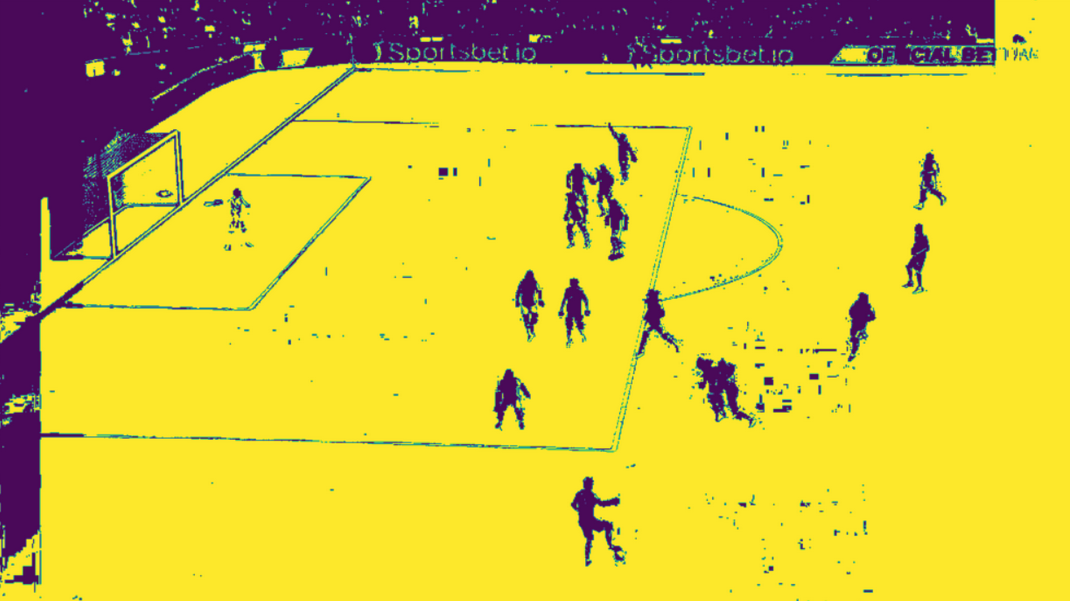

We draw the augmentation on a separate black canvas first. This is initialized with the following line, and all the graphical elements are drawn on top of it: 

In [35]:
drawing_canvas = np.zeros(image_np.shape[:3], dtype="uint8")

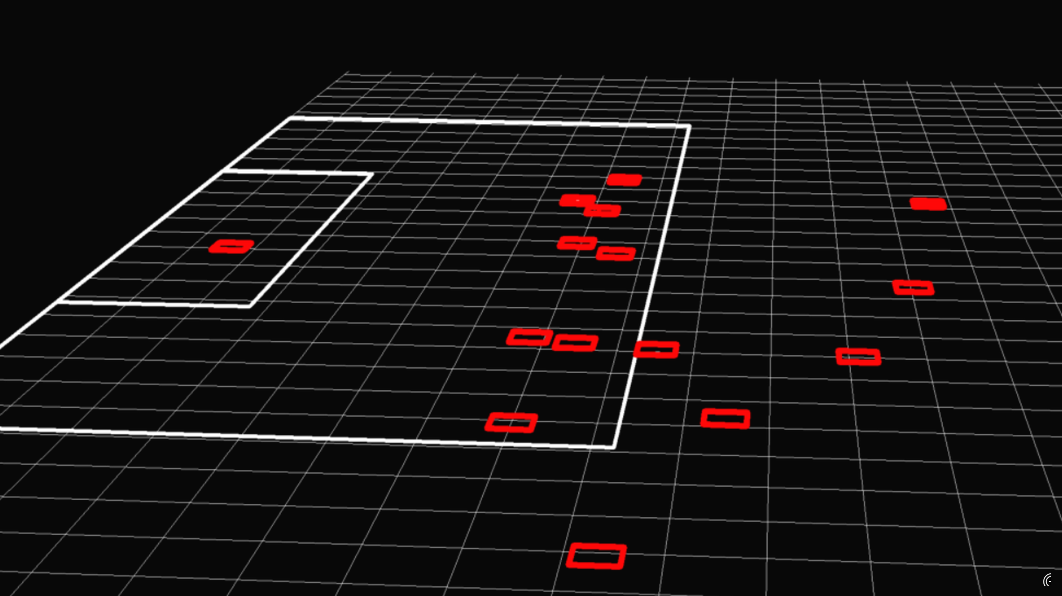

Next, we combine the mask with the augmentation, so that the augmentations are only drawn on pixels that are identified as field (or field lines). Notice how the augmentations have been removed in the places where the players are.

In [36]:
drawing_canvas_masked = cv2.bitwise_and(drawing_canvas, drawing_canvas, mask=white_or_green_mask)

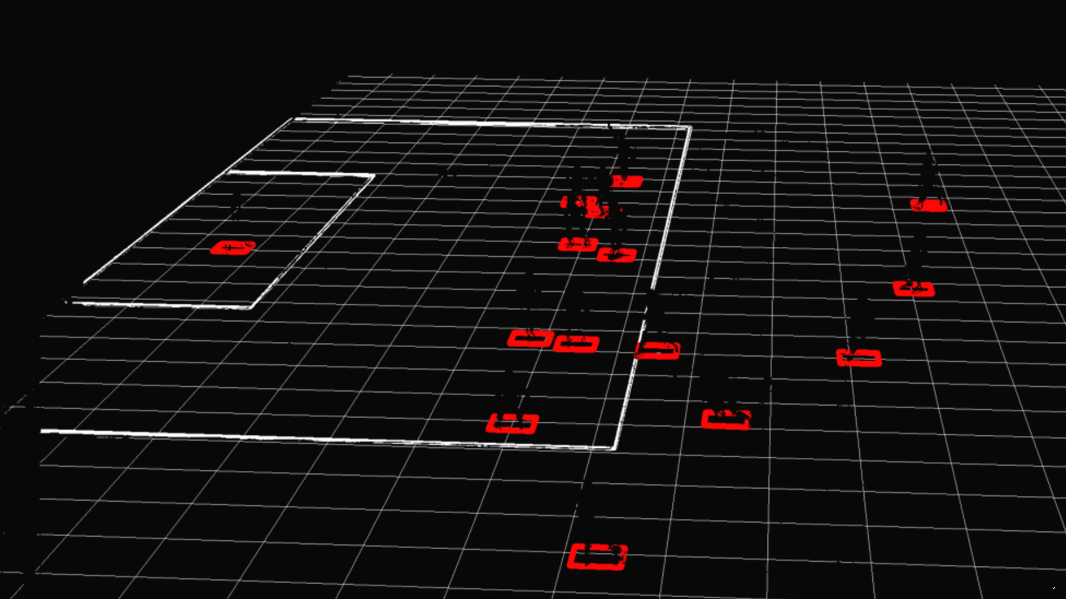

Lastly, we overlay the masked augmentation on top of the original.

In [37]:
img_augmented = cv2.bitwise_or(drawing_canvas_masked, image_np)

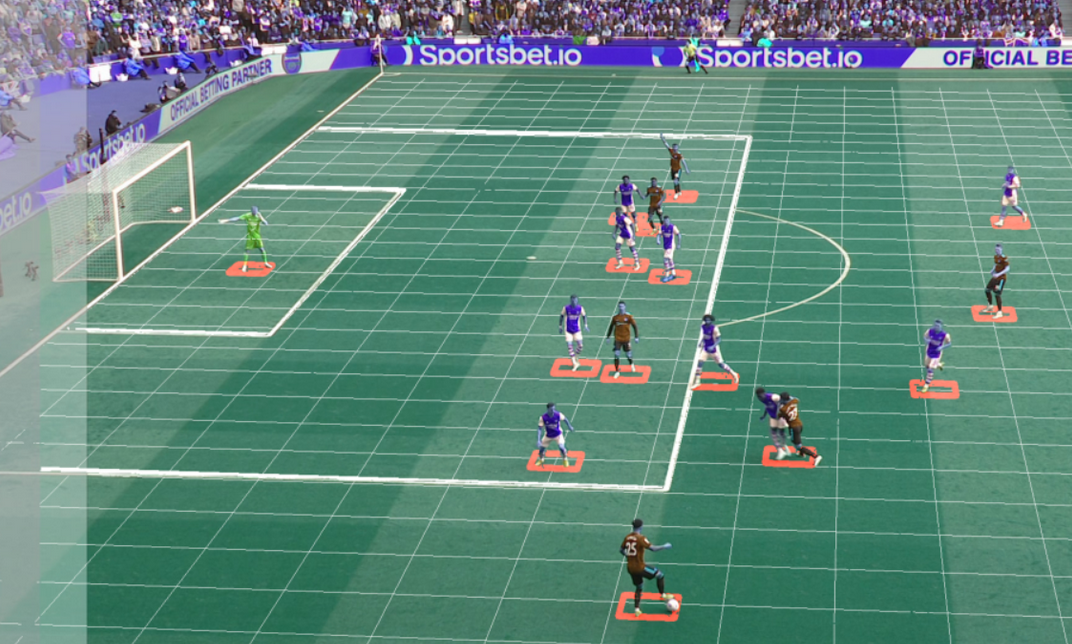

Once the notebook has finished processing, you can download the video

#### Task : Run the code for another video
**Make it with another video:**

    wget https://objectstorage.us-ashburn-1.oraclecloud.com/p/U4c38N1vkSezFW9TYqt6yfs70atBdeReiQA009FuMYxkN6ycSHK7J4K4iSYCvh1L/n/c4u04/b/livelabsfiles/o/ai-ml-library/video2.mp4 -O video2.mp4

In [38]:
# Connect to the database
!pip install oracledb

#COMMENT THE FOLLOWING LINE IF YOU NOT WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
connection, cur = initialize_database_connection_and_table()

# Read the precalculated homography translation matrices (for all frames)
f = open('coordinate_pairs2.json', 'r')
homographyStr = f.read()
homographyDict = json.loads(homographyStr)

# Configure features parameter for call to AI Vision service
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()
image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = 50 # We don't expect more than 50 objects
image_text_detection_feature = oci.ai_vision.models.ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]

# Video reader
filename = 'video2.mp4'
cap = cv2.VideoCapture(filename)

# Video writer
out = cv2.VideoWriter('soccer_out.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (1920, 1080))

#Remove the first few frames (because it has a video overlay on top of the field)
for i in range(1, 15):
    ret, image_np = cap.read()
    
tracked_players = [] # Empty list

frame_number = 6
while (frame_number <= 80):
    # Read three frames from the video (we are skipping 2 frames, then processing the third)
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    _, im_arr = cv2.imencode('.jpg', image_np)  # im_arr: image in Numpy one-dim array format.
    
    # Call the AI Vision service to do object recognition and text recognition
    im_bytes = im_arr.tobytes()
    im_b64 = base64.b64encode(im_bytes)
    inline_image_details.data = im_b64.decode('utf-8')
    analyze_image_details.image = inline_image_details
    analyze_image_details.features = features
    res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)
    res_json = json.loads(repr(res.data))
    
    # Calculate the translation matrix for the current frame
    frame_coordinate_pairs = homographyDict[str(frame_number)]
    pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
    pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
    camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
    field_to_camera, status = cv2.findHomography(pts_dst, pts_src)

    # Data enrichment
    add_object_world_coordinates(res_json["image_objects"], image_np, camera_to_field)
    remove_unwanted_objects(res_json["image_objects"])
    add_shirt_number_to_players(res_json)
    tracked_players = enrich_shirt_numbers_from_tracked_players(res_json["image_objects"], tracked_players)

    # Create a mask for the underlying field (all the green pixels + some white pixels for the lines)
    img_hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(image_np, (213, 225, 204), (255, 255, 255))
    lower_green = np.array([40,40, 40])
    upper_green = np.array([70, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
    white_or_green_mask = cv2.bitwise_or(green_mask, white_mask)
    
    # Create an image of the same size as the original that will contain the augmentation elements (field lines, player marks, et cetera)
    drawing_canvas = np.zeros(image_np.shape[:3], dtype="uint8")
    #drawPlayerBoxes(clean_res, image_np)
    draw_field(drawing_canvas)
    draw_player_field_markers(res_json["image_objects"], drawing_canvas, field_to_camera)
    draw_player_info(res_json["image_objects"], drawing_canvas)
    
    # Remove the drawn elements in areas where there are no field pixels (effectively not drawing where there is a player or ball)
    drawing_canvas_masked = cv2.bitwise_and(drawing_canvas, drawing_canvas, mask=white_or_green_mask)
    img_augmented = cv2.bitwise_or(drawing_canvas_masked, image_np)

    #plt.imshow(img_augmented)
    #plt.gcf().set_dpi(200)
    #plt.show()
    
    # Add the resulting frame (with annotation) to the output video
    print("Writing to video, frame", frame_number)
    out.write(img_augmented)
    
    #COMMENT THE FOLLOWING LINE IF YOU NOT WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
    store_tracking_information(res_json["image_objects"], frame_number, connection, cur)

    frame_number += 1
cap.release()
out.release()

Could not create the tracking table, moving on...
Ignoring non-number shirt text Rist
Writing to video, frame 6
Writing to video, frame 7
Writing to video, frame 8
Writing to video, frame 9
Writing to video, frame 10
Writing to video, frame 11
Writing to video, frame 12
Writing to video, frame 13
Writing to video, frame 14
Writing to video, frame 15
Writing to video, frame 16
Writing to video, frame 17
Writing to video, frame 18
Writing to video, frame 19
Writing to video, frame 20
Writing to video, frame 21
Ignoring non-number shirt text A AIA AIA AIA AIA IA A AIA AIA AA AIA
Writing to video, frame 22
Writing to video, frame 23
Ignoring non-number shirt text AIA AIAA
Ignoring non-number shirt text A A AIA AIA A AIA
Writing to video, frame 24
Writing to video, frame 25
Ignoring non-number shirt text NA AIA IA AS AIA AIA A AIA
Writing to video, frame 26
Found shirt number 12
Ignoring non-number shirt text NA AIA AIA A A' AIA AIA A AIA
Writing to video, frame 27
Found shirt number 112
Wr

If you download the video, you can see that the AI can make some errors when a person come out of camera. But it quite good